In [46]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sc
from scipy import signal
import matplotlib.pylab as pl
import time
import cv2 as cv

In [18]:
def costMatrixConvolution(b, nl, nc, F, eps, alpha):    
    # Construction du vecteur de distance sur l'axe des colonnes
    tc = np.linspace(0,1,nc)
    vect1 = np.array(list(reversed(tc)))
    vect2 = np.array(list(tc))
    vect2 = vect2[1:nc]
    G1 = np.exp(-vect1**2/eps)
    G2 = np.exp(-vect2**2/eps)
    G = np.concatenate((G1, G2))

    # Construction du vecteur de distance sur l'axe des lignes
    tl = np.linspace(0,1,nl)
    vect1 = np.array(list(reversed(tl)))
    vect2 = np.array(list(tl))
    vect2 = vect2[1:nl]
    V_p1 = np.exp(-vect1**2/eps)
    V_p2 = np.exp(-vect2**2/eps)
    V_p = np.concatenate((V_p1, V_p2))
    
    # Construction du vecteur de distance sur l'axe des couleurs
    tb = np.linspace(0,1,b)
    vect1 = np.array(list(reversed(tb)))
    vect2 = np.array(list(tb))
    vect2 = vect2[1:b]
    V1 = np.exp(-(alpha*vect1**2)/eps)
    V2 = np.exp(-(alpha*vect2**2)/eps)
    V = np.concatenate((V1, V2))
    
    
    #On init le vecteur R qui va contenir les convolutions K_i*F_i
    R = []
    #On commence à boucler sur le nombre de couleurs
    for i in range(b):
        #On extrait le vecteur Fi de F
        F_i = F[i*(nc*nl):(i+1)*(nc*nl)]
        #On init le vecteur R' qui va contenir les convolutions K_i_j*F_ij
        R_p = []
        
        #On boucle ensuite sur le nombre de lignes pour faire les opérations de convolutions
        for j in range(nl):
            #On extrait le vecteur Fi,j de F pour faire les convolutions dessus
            F_i_j = F_i[j*(nc):(j+1)*nc]
            #Convolution sur ce vecteur
            tmp = sc.signal.fftconvolve(G, F_i_j)
            Res = tmp[nc-1:2*nc - 1]
            R_p.append(Res)
            
        R_p = np.array(R_p) #Met en array pour pouvoir faire les calculs dessus -> On a ici le vecteur R'(0->nl-1)
                            #contenant les convolutions : les vecteurs R'(i) sont de taille nc pour 0<i<nl-1
        
        #On construit ici la convolution : V'*R'
        tmp = np.array(sc.signal.fftconvolve(V_p, R_p[:,0]))
        Qi = tmp[nl - 1:2*nl - 1]
        for k in range(nc-1):
            tmp = sc.signal.fftconvolve(V_p, R_p[:,k+1])
            Qi = np.block([[Qi], [tmp[nl - 1:2*nl - 1]]])

        Qi = np.transpose(Qi)
        A = Qi[0]
        for k in range(Qi.shape[0]-1):
            A = np.concatenate((A, Qi[k+1]), axis=None)
        
        R.append(A)

    R = np.array(R) #Met en array pour pouvoir faire les calculs dessus -> On a ici le vecteur R(0->b-1)
                       #contenant les convolutions : les vecteurs R(i) sont de taille nl pour 0<i<b-1

    #On construit ici la convolution : V*R qui est le résultat final K*F

    tmp = np.array(sc.signal.fftconvolve(V, R[:,0]))
    Q = tmp[b - 1:2*b - 1]
    for l in range((nl*nc)-1):
        tmp = sc.signal.fftconvolve(V, R[:,l+1])
        Q = np.block([[Q], [tmp[b - 1:2*b - 1]]])
    
    
    Q = np.transpose(Q)
    finalRes = Q[0]
    for k in range(Q.shape[0]-1):
            finalRes = np.concatenate((finalRes, Q[k+1]), axis=None)
    
    return finalRes

In [19]:
def im2vect(Img):
    b = Img.shape[2]
    nL = Img.shape[0]
    nC = Img.shape[1]
    vect = []
    for i in range(b):
        for j in range(nL):
            vect = np.concatenate((vect, Img[j,:,i].tolist()), axis=None)
    return vect    


def vect2Im(vect, shape):
    b = shape[2]
    nL = shape[0]
    nC = shape[1]
    image = []
    for k in range(nL):
        C = []
        for i in range(nC):
            B = []
            for j in range(b):
                  B = np.concatenate((B, vect[j*nC*nL + i + k*nC]), axis = None)
            C.append(B.tolist())
        image.append(C)
    image = np.array(image)
    return image

In [185]:
def convBarycenter(m, h, epsilon, alpha, Lambda, nbIter): #Fonction calcul de barycentre pour images de même taille
    nL = m.shape[0]
    nC = m.shape[1]
    b = m.shape[2]
    #v_m = np.ones(b*nL*nC)
    #v_h = np.ones(b*nL*nC)
    u_m = np.ones(b*nL*nC)
    u_h = np.ones(b*nL*nC)
    m_vect = im2vect(m)
    h_vect = im2vect(h)    
    for i in range(nbIter):
        v_m = m_vect/costMatrixConvolution(b, nL, nC, u_m, epsilon, alpha)
        v_h = h_vect/costMatrixConvolution(b, nL, nC, u_h, epsilon, alpha)
        convo_v_m = costMatrixConvolution(b, nL, nC, v_m, epsilon, alpha)
        convo_v_h = costMatrixConvolution(b, nL, nC, v_h, epsilon, alpha)
        f = np.exp(Lambda*np.log(u_m*convo_v_m) + (1-Lambda)*np.log(u_h*convo_v_h))
        
        u_m = f/convo_v_m
        u_h = f/convo_v_h
    
    res = vect2Im(f, m.shape)
    return res

def convBarycenter2(m, h, epsilon, alpha, Lambda, nbIter): #Fonction calcul de barycentre pour images de même taille
    stabThr = 1e-30
    nL = m.shape[0]
    nC = m.shape[1]
    b = m.shape[2]
    #v_m = np.ones(b*nL*nC)
    #v_h = np.ones(b*nL*nC)
    u_m = np.ones(b*nL*nC)
    u_h = np.ones(b*nL*nC)
    m_vect = im2vect(m)
    h_vect = im2vect(h)    
    for i in range(nbIter):
        v_m = m_vect/np.maximum(costMatrixConvolution(b, nL, nC, u_m, epsilon, alpha), stabThr)
        v_h = h_vect/np.maximum(costMatrixConvolution(b, nL, nC, u_h, epsilon, alpha), stabThr)
        convo_v_m = costMatrixConvolution(b, nL, nC, v_m, epsilon, alpha)
        convo_v_h = costMatrixConvolution(b, nL, nC, v_h, epsilon, alpha)
        f = np.exp(Lambda*np.log(np.maximum(u_m*convo_v_m, stabThr)) + (1-Lambda)*np.log(np.maximum(u_h*convo_v_h, stabThr)))
        
        u_m = f/np.maximum(convo_v_m, stabThr)
        u_h = f/np.maximum(convo_v_h, stabThr)
    
    res = vect2Im(f, m.shape)
    return res

def normalize(im):
    imNorm = np.zeros((im.shape))
    for i in range(im.shape[2]):
        if np.sum(im[:,:,i]) != 0:
            imNorm[:,:,i] = im[:,:,i]/np.sum(im[:,:,i])
        else:
            imNorm[:,:,i] = im[:,:,i]
    return imNorm


# Test 1 : mêmes bandes spectrales

In [361]:
Im1 = np.zeros((100,100,3))
Im2 = np.zeros((100,100,3))

In [362]:
for i in range(100):
    for j in range(100):
        if (i>=20 and i<=40) and (j>=20 and j<=40):
            Im1[i,j,0] = 0.8
            Im1[i,j,1] = 0
            Im1[i,j,2] = 0
            
        if (i>=20 and i<=40) and (j>=60 and j<=80):
            Im2[i,j,0] = 0.8
            Im2[i,j,1] = 0
            Im2[i,j,2] = 0

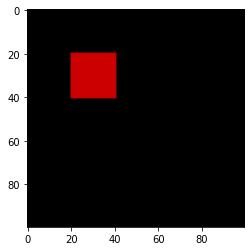

In [363]:
plt.imshow(Im1)

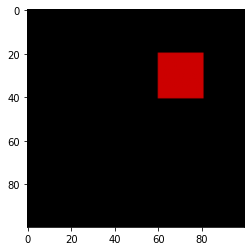

In [364]:
plt.imshow(Im2)

In [365]:
Im1 = normalize(Im1)
Im2 = normalize(Im2)

In [366]:
t0 = time.time()
barycenter = convBarycenter2(Im1, Im2, 0.01, 5, 0.5, 5 )
t1 = time.time()
print('process time for barycenter calculation in 10 iterations: ', t1-t0)

process time for barycenter calculation in 10 iterations:  38.342859506607056


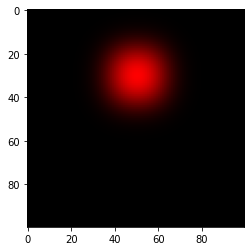

In [367]:
BCmod = np.zeros((barycenter.shape))
BCmod[:,:,0] = barycenter[:,:,0]*(1/barycenter.max())
BCmod[:,:,1] = barycenter[:,:,1]*(1/barycenter.max())
BCmod[:,:,2] = barycenter[:,:,2]*(1/barycenter.max())
plt.imshow(BCmod)

# Test 1 BIS

In [368]:
Im1 = np.zeros((100,100,3))
Im2 = np.zeros((100,100,3))

In [369]:
for i in range(100):
    for j in range(100):
        if (i>=20 and i<=40) and (j>=20 and j<=40):
            Im1[i,j,0] = 0.8
            Im1[i,j,1] = 0
            Im1[i,j,2] = 0
            
        if (i>=60 and i<=80) and (j>=60 and j<=80):
            Im2[i,j,0] = 0.8
            Im2[i,j,1] = 0
            Im2[i,j,2] = 0

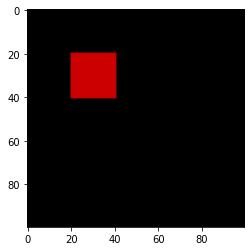

In [370]:
plt.imshow(Im1)

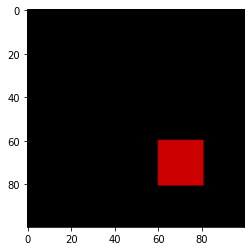

In [371]:
plt.imshow(Im2)

In [372]:
Im1 = normalize(Im1)
Im2 = normalize(Im2)

In [373]:
t0 = time.time()
barycenter = convBarycenter2(Im1, Im2, 0.01, 5, 0.5, 5 )
t1 = time.time()
print('process time for barycenter calculation in 10 iterations: ', t1-t0)

process time for barycenter calculation in 10 iterations:  33.08009314537048


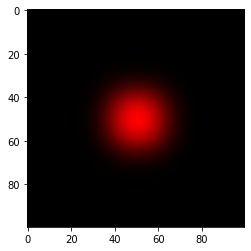

In [374]:
BCmod = np.zeros((barycenter.shape))
BCmod[:,:,0] = barycenter[:,:,0]*(1/barycenter.max())
BCmod[:,:,1] = barycenter[:,:,1]*(1/barycenter.max())
BCmod[:,:,2] = barycenter[:,:,2]*(1/barycenter.max())
plt.imshow(BCmod)

# Test 2 : même image spatiale

In [375]:
Im1 = np.zeros((100,100,3))
Im2 = np.zeros((100,100,3))

In [376]:
for i in range(100):
    for j in range(100):
        if (i>=20 and i<=40) and (j>=20 and j<=40):
            Im1[i,j,0] = 0.8
            Im1[i,j,1] = 0
            Im1[i,j,2] = 0
            Im2[i,j,0] = 0
            Im2[i,j,1] = 0.8
            Im2[i,j,2] = 0

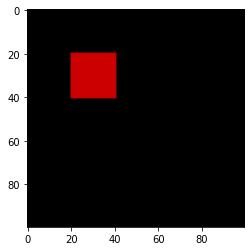

In [377]:
plt.imshow(Im1)

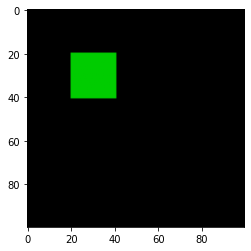

In [378]:
plt.imshow(Im2)

In [379]:
Im1 = normalize(Im1)
Im2 = normalize(Im2)

In [380]:
t0 = time.time()
barycenter = convBarycenter2(Im1, Im2, 0.01, 5, 0.1, 5)
t1 = time.time()
print('process time for barycenter calculation in 10 iterations: ', t1-t0)

process time for barycenter calculation in 10 iterations:  38.89944887161255


In [381]:
barycenter[:,:,:].max()
BCmod = np.zeros((barycenter.shape))
BCmod[:,:,0] = barycenter[:,:,0]*(1/barycenter.max())
BCmod[:,:,1] = barycenter[:,:,1]*(1/barycenter.max())
BCmod[:,:,2] = barycenter[:,:,2]*(1/barycenter.max())

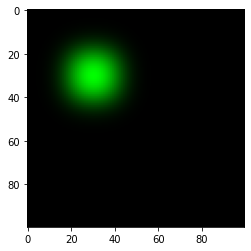

In [382]:
plt.imshow(BCmod)

# Test 3 : Flou directionnel

In [255]:
I1 = plt.imread('data/coucher.jpg')
I1 = I1[100:250, 450:650, :]/255

In [256]:
kernel_size = 30

In [257]:
Kd1 = np.eye(kernel_size)/kernel_size
Kd2 = np.zeros((kernel_size,kernel_size))
for i in range(kernel_size):
    Kd2[kernel_size-(i+1),i] = 1

Kd2 = Kd2/kernel_size
Im1 = cv.filter2D(I1, -1, Kd1)
Im2 = cv.filter2D(I1, -1, Kd2)

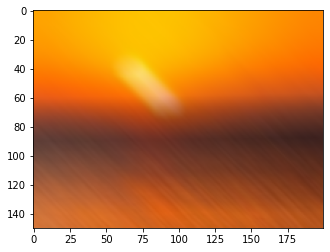

In [258]:
plt.imshow(Im1)

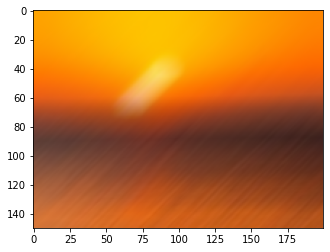

In [259]:
plt.imshow(Im2)

In [260]:
Im1 = normalize(Im1)
Im2 = normalize(Im2)

In [261]:
t0 = time.time()
barycenter = convBarycenter(Im1, Im2, 0.001, 5, 0.5, 1)
t1 = time.time()
print('process time for barycenter calculation in 10 iterations: ', t1-t0)

process time for barycenter calculation in 10 iterations:  20.277779579162598


In [262]:
BCmod = np.zeros((barycenter.shape))
BCmod[:,:,0] = barycenter[:,:,0]*(1/barycenter[:,:,0].max())
BCmod[:,:,1] = barycenter[:,:,1]*(1/barycenter[:,:,1].max())
BCmod[:,:,2] = barycenter[:,:,2]*(1/barycenter[:,:,2].max())

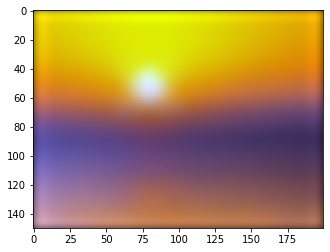

In [263]:
plt.imshow(BCmod)

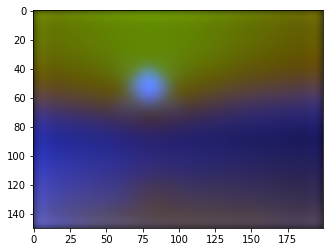

In [264]:
BCmod1 = np.zeros((barycenter.shape))
BCmod1[:,:,0] = barycenter[:,:,0]*(1/barycenter.max())
BCmod1[:,:,1] = barycenter[:,:,1]*(1/barycenter.max())
BCmod1[:,:,2] = barycenter[:,:,2]*(1/barycenter.max())
plt.imshow(BCmod1)

# Test 4 : Flou Spatial et Flou Spectral

In [272]:
I1 = plt.imread('data/coucher.jpg')
I1 = I1[100:250, 450:650, :]/255

In [273]:
Im1 = cv.blur(I1,(10,10)) 

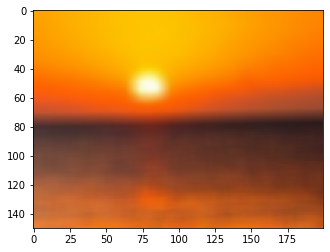

In [274]:
plt.imshow(Im1)

In [275]:
Im2 = np.zeros((I1.shape))
for i in range(Im2.shape[0]):
    for j in range(Im2.shape[1]):
        Im2[i,j,0] = 1/3*(I1[i,j,0]+I1[i,j,1]+I1[i,j,2])
        Im2[i,j,1] = 1/3*(I1[i,j,0]+I1[i,j,1]+I1[i,j,2])
        Im2[i,j,2] = 1/3*(I1[i,j,0]+I1[i,j,1]+I1[i,j,2])

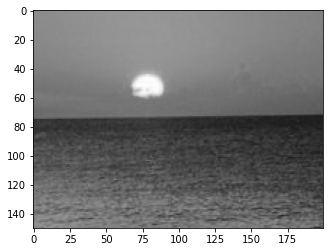

In [276]:
plt.imshow(Im2)

In [277]:
Im1 = normalize(Im1)
Im2 = normalize(Im2)

In [278]:
t0 = time.time()
barycenter = convBarycenter2(Im1, Im2, 0.001, 5, 0.1, 1 )
t1 = time.time()
print('process time for barycenter calculation in 10 iterations: ', t1-t0)

process time for barycenter calculation in 10 iterations:  20.323096752166748


In [279]:
BCmod = np.zeros((barycenter.shape))
BCmod[:,:,0] = barycenter[:,:,0]*(1/barycenter[:,:,0].max())
BCmod[:,:,1] = barycenter[:,:,1]*(1/barycenter[:,:,1].max())
BCmod[:,:,2] = barycenter[:,:,2]*(1/barycenter[:,:,2].max())

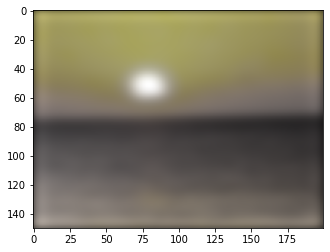

In [280]:
plt.imshow(BCmod)

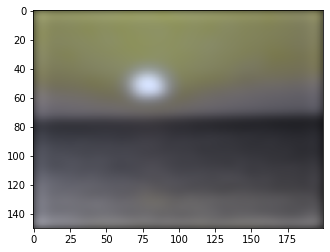

In [281]:
BCmod1 = np.zeros((barycenter.shape))
BCmod1[:,:,0] = barycenter[:,:,0]*(1/barycenter.max())
BCmod1[:,:,1] = barycenter[:,:,1]*(1/barycenter.max())
BCmod1[:,:,2] = barycenter[:,:,2]*(1/barycenter.max())
plt.imshow(BCmod1)

# Test 5 : Deux images avec zones différentes

In [282]:
I1 = plt.imread('data/coucher.jpg')
I2 = plt.imread('data/ocean.jpg')
I1 = I1[100:250, 450:650, :]/255
I2 = I2[250:400,380:580,:]/255

In [283]:
Im1 = I1.copy()
Im2 = I1.copy()
for i in range(20):
    for j in range(20):
        Im2[i+40,j+70,0] = I2[i+80,j+70,0]
        Im2[i+40,j+70,1] = I2[i+80,j+70,1]
        Im2[i+40,j+70,2] = I2[i+80,j+70,2]

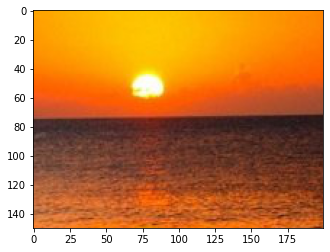

In [284]:
plt.imshow(Im1)

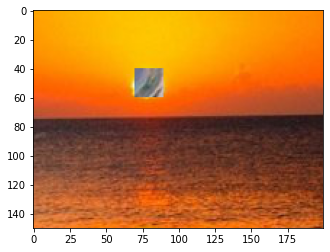

In [285]:
plt.imshow(Im2)

In [286]:
Im1 = normalize(Im1)
Im2 = normalize(Im2)

In [287]:
t0 = time.time()
barycenter = convBarycenter(Im1, Im2, 0.001, 5, 0.1, 1 )
t1 = time.time()
print('process time for barycenter calculation in 10 iterations: ', t1-t0)

process time for barycenter calculation in 10 iterations:  18.75877571105957


In [288]:
BCmod = np.zeros((barycenter.shape))
BCmod[:,:,0] = barycenter[:,:,0]*(1/barycenter[:,:,0].max())
BCmod[:,:,1] = barycenter[:,:,1]*(1/barycenter[:,:,1].max())
BCmod[:,:,2] = barycenter[:,:,2]*(1/barycenter[:,:,2].max())

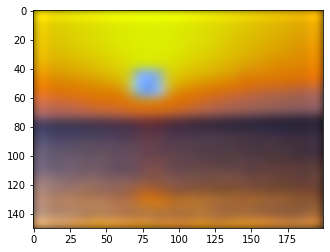

In [289]:
plt.imshow(BCmod)

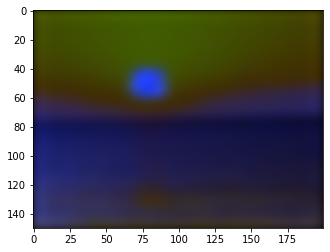

In [290]:
BCmod1 = np.zeros((barycenter.shape))
BCmod1[:,:,0] = barycenter[:,:,0]*(1/barycenter.max())
BCmod1[:,:,1] = barycenter[:,:,1]*(1/barycenter.max())
BCmod1[:,:,2] = barycenter[:,:,2]*(1/barycenter.max())
plt.imshow(BCmod1)

# Test 6 : Memes images

In [291]:
I1 = plt.imread('data/coucher.jpg')
Im1 = I1[100:250, 450:650, :]/255

In [292]:
Im1 = normalize(Im1)
Im2 = normalize(Im2)

In [293]:
t0 = time.time()
barycenter = convBarycenter(Im1, Im1, 0.001, 5, 0.1, 1 )
t1 = time.time()
print('process time for barycenter calculation in 10 iterations: ', t1-t0)

process time for barycenter calculation in 10 iterations:  23.419023990631104


In [294]:
BCmod = np.zeros((barycenter.shape))
BCmod[:,:,0] = barycenter[:,:,0]*(1/barycenter[:,:,0].max())
BCmod[:,:,1] = barycenter[:,:,1]*(1/barycenter[:,:,1].max())
BCmod[:,:,2] = barycenter[:,:,2]*(1/barycenter[:,:,2].max())

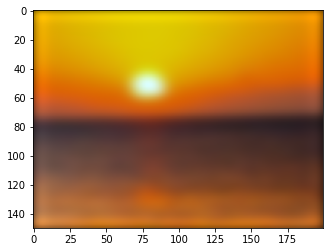

In [295]:
plt.imshow(BCmod)

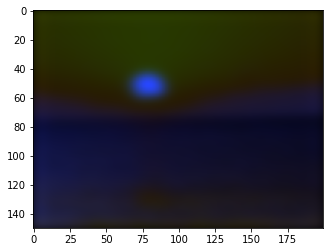

In [296]:
BCmod1 = np.zeros((barycenter.shape))
BCmod1[:,:,0] = barycenter[:,:,0]*(1/barycenter.max())
BCmod1[:,:,1] = barycenter[:,:,1]*(1/barycenter.max())
BCmod1[:,:,2] = barycenter[:,:,2]*(1/barycenter.max())
plt.imshow(BCmod1)

# Test 7 : Deux images différentes

In [236]:
I1 = plt.imread('data/coucher.jpg')
I2 = plt.imread('data/ocean.jpg')
Im1 = I1[100:250, 450:650, :]/255
Im2 = I2[250:400,380:580,:]/255

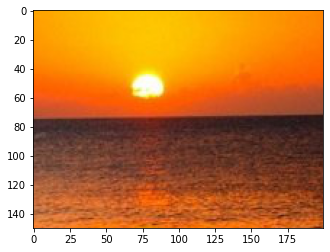

In [237]:
plt.imshow(Im1)

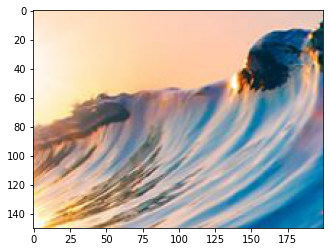

In [238]:
plt.imshow(Im2)

In [239]:
Im1 = normalize(Im1)
Im2 = normalize(Im2)

In [251]:
t0 = time.time()
barycenter = convBarycenter(Im2, Im1, 0.001, 5, 0.5, 1 )
t1 = time.time()
print('process time for barycenter calculation in 10 iterations: ', t1-t0)

process time for barycenter calculation in 10 iterations:  20.273112535476685


In [252]:
BCmod = np.zeros((barycenter.shape))
BCmod[:,:,0] = barycenter[:,:,0]*(1/barycenter[:,:,0].max())
BCmod[:,:,1] = barycenter[:,:,1]*(1/barycenter[:,:,1].max())
BCmod[:,:,2] = barycenter[:,:,2]*(1/barycenter[:,:,2].max())

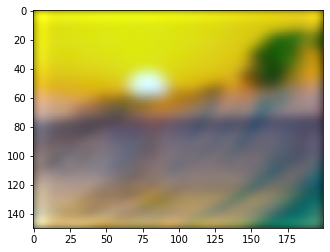

In [253]:
plt.imshow(BCmod)

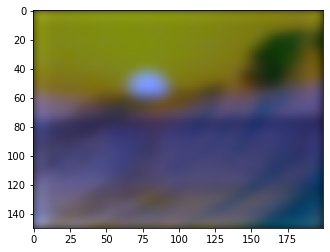

In [254]:
BCmod1 = np.zeros((barycenter.shape))
BCmod1[:,:,0] = barycenter[:,:,0]*(1/barycenter.max())
BCmod1[:,:,1] = barycenter[:,:,1]*(1/barycenter.max())
BCmod1[:,:,2] = barycenter[:,:,2]*(1/barycenter.max())
plt.imshow(BCmod1)